In [2]:
!pip install statsmodels

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [52]:
import pandas as pd
from random import random

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dump2.csv', na_filter=True)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

'''
'cpu_percent', 'cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                   'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches', 'cpu_numbers_of_interrupts',
                   'cpu_numbers_of_soft_interrupts','cpu_load_runable_state','memory_percent','memory_active',
                   'memory_cached','memory_shared','memory_swap_percent','memory_swap_sin','memory_swap_sout',
                   'disk_usage_percent','disk_read_count','disk_write_count','disk_read_time','disk_write_time'
'''

df = df.drop(columns=['cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                   'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches', 'cpu_numbers_of_interrupts',
                   'cpu_numbers_of_soft_interrupts','cpu_load_runable_state','memory_active',
                   'memory_cached','memory_shared','memory_swap_percent','memory_swap_sin','memory_swap_sout',
                   'disk_read_count','disk_write_count','disk_read_time','disk_write_time'])

print(df.shape)  # (2503, 23)
df.tail()

(2503, 4)


,cpu_percent,cpu_irq,memory_percent,disk_usage_percent
2498,0.7,0,2983067648,318953
2499,0.7,0,2983067648,318953
2500,1.3,0,2983071744,318953
2501,0.8,0,2983079936,318953
2502,0.9,0,2983092224,318953


In [4]:
def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

drop_col = remove_constant_value_features(df)
df.drop(drop_col,axis=1,inplace=True)
print(df.shape)  # (2503, 23)
df.tail()

(2503, 3)


,cpu_percent,memory_percent,disk_usage_percent
2498,0.7,2983067648,318953
2499,0.7,2983067648,318953
2500,1.3,2983071744,318953
2501,0.8,2983079936,318953
2502,0.9,2983092224,318953


In [101]:
#new
df = pd.DataFrame({'cpu_percent':[x + random()*10 for x in range(0, 1000)],
                         'memory_percent':50+np.sin(np.linspace(0, 2*np.pi, 1000))*50})
df_test = pd.DataFrame({'cpu_percent':[x + random()*10 for x in range(1001, 2001)],
                         'memory_percent':50+np.sin(np.linspace(0, 2*np.pi, 1000))*50})
df_train = df
# df = pd.concat([df_train, df_test])
# df

In [ ]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(18,24))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


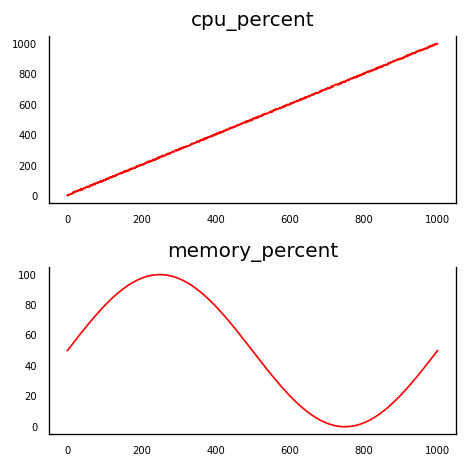

In [102]:
#new
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(4,4))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=40
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

In [103]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
cpu_percent ::  335.97    > 12.3212   =>   True
memory_percent ::  0.0       > 4.1296    =>   False


In [ ]:
nobs = 500
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (2403, 22)
print(df_test.shape)  # (100, 22)

In [75]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [104]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cpu_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.1325
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9461. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "memory_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28341672870860.152
 No. Lags Chosen       = 13
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [105]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [106]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cpu_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.441
 No. Lags Chosen       = 19
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "memory_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7334287348.7156
 No. Lags Chosen       = 1
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [ ]:
# Second Differencing
#df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [107]:
model = VAR(df_differenced)
for i in range(1,40,1):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  -10.587034689383897
BIC :  -10.557541182712685
FPE :  2.5241157712770846e-05
HQIC:  -10.575824009556168 

Lag Order = 2
AIC :  -59.38028161810165
BIC :  -59.3310865251231
FPE :  1.6273142686152043e-26
HQIC:  -59.36158132337608 

Lag Order = 3
AIC :  -61.001385628112466
BIC :  -60.932457453809064
FPE :  3.216881286362587e-27
HQIC:  -60.9751830160041 

Lag Order = 4
AIC :  -61.41499677406442
BIC :  -61.326303940628385
FPE :  2.1271897099152853e-27
HQIC:  -61.38127910782584 

Lag Order = 5
AIC :  -61.6547917761726
BIC :  -61.546302622705355
FPE :  1.6736511240874297e-27
HQIC:  -61.61354628466778 

Lag Order = 6
AIC :  -61.952191241129796
BIC :  -61.823874023340096
FPE :  1.2431012454902415e-27
HQIC:  -61.903405118707326 

Lag Order = 7
AIC :  -61.99959063975492
BIC :  -61.85141352965558
FPE :  1.1855555478384017e-27
HQIC:  -61.94325104612071 

Lag Order = 8
AIC :  -62.16811639316757
BIC :  -62.00004747877078
FPE :  1.0016892748469426e-27
HQIC:  -62.10421045325688 

La

In [ ]:
x = model.select_order(maxlags=40)
x.summary()

In [108]:
model_fitted = model.fit(12)
model_fitted.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Apr, 2023
Time:                     18:42:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -62.1728
Nobs:                     987.000    HQIC:                  -62.3264
Log likelihood:           28053.6    FPE:                7.78088e-28
AIC:                     -62.4207    Det(Omega_mle):     7.40120e-28
--------------------------------------------------------------------
Results for equation cpu_percent
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             6.455260         0.467267           13.815           0.000
L1.cpu_percent                   -0.958633         0.032178          -29.792           0.000
L1.mem

In [109]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

cpu_percent : 2.0
memory_percent : 2.08


In [110]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

12


array([[ 2.20248769,  0.313651  ],
       [-5.94055109,  0.31378773],
       [ 5.15272121,  0.31391204],
       [ 0.78430053,  0.31402394],
       [ 5.60614616,  0.31412342],
       [-0.01151858,  0.31421047],
       [-4.21884018,  0.31428509],
       [ 1.24200482,  0.31434728],
       [-1.10530859,  0.31439703],
       [ 0.43111833,  0.31443435],
       [ 3.82327271,  0.31445923],
       [ 1.42253144,  0.31447167]])

In [111]:
df_differenced.values.shape

(999, 2)

In [112]:
#new
nobs=999
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,cpu_percent_1d,memory_percent_1d
1,1.588867,0.314472
2,0.738770,0.314459
3,0.368652,0.314434
4,1.396973,0.314397
5,1.145020,0.314347
...,...,...
995,1.001953,0.314347
996,1.002686,0.314397
997,1.004150,0.314434
998,1.004883,0.314459


In [113]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,cpu_percent_1d,memory_percent_1d
1,1.588867,0.314472
2,0.738770,0.314459
3,0.368652,0.314434
4,1.396973,0.314397
5,1.145020,0.314347
...,...,...
995,1.001953,0.314347
996,1.002686,0.314397
997,1.004150,0.314434
998,1.004883,0.314459


In [114]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [115]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)    
'''    
df_results.loc[:, ['cpu_percent_forecast', 'cpu_user_time_forecast', 'cpu_system_time_forecast', 'cpu_idle_time_forecast',
                   'cpu_iowait_forecast', 'cpu_softirq_forecast', 'cpu_numbers_of_ctx_switches_forecast', 'cpu_numbers_of_interrupts_forecast',
                   'cpu_numbers_of_soft_interrupts_forecast','cpu_load_runable_state_forecast','memory_percent_forecast','memory_active_forecast',
                   'memory_cached_forecast','memory_shared_forecast','memory_swap_percent_forecast','memory_swap_sin_forecast','memory_swap_sout_forecast',
                   'disk_usage_percent_forecast','disk_read_count_forecast','disk_write_count_forecast','disk_read_time_forecast','disk_write_time_forecast']]
'''

df_results.loc[:, ['cpu_percent_forecast','memory_percent_forecast','disk_usage_percent_forecast']]

KeyError: ignored

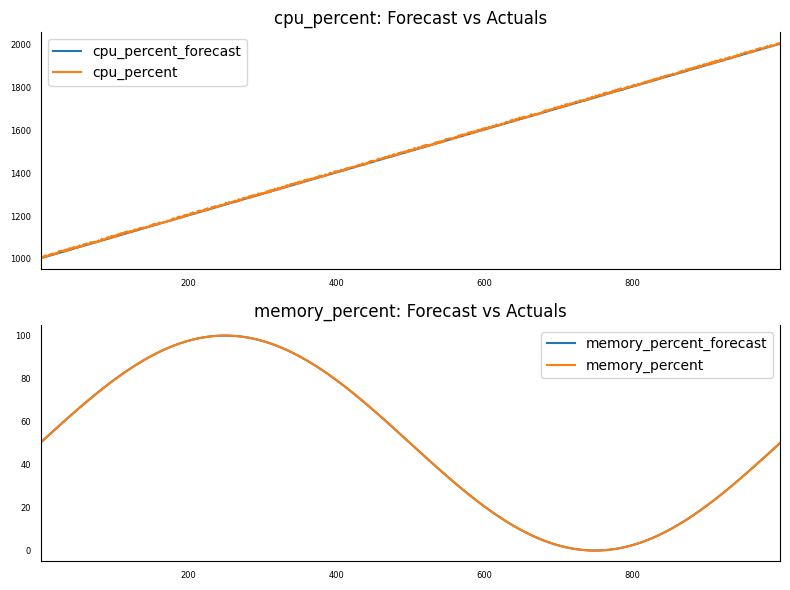

In [121]:
#new
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()


fig, axes = plt.subplots(nrows=2, ncols=1, dpi=100, figsize=(8,6))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();




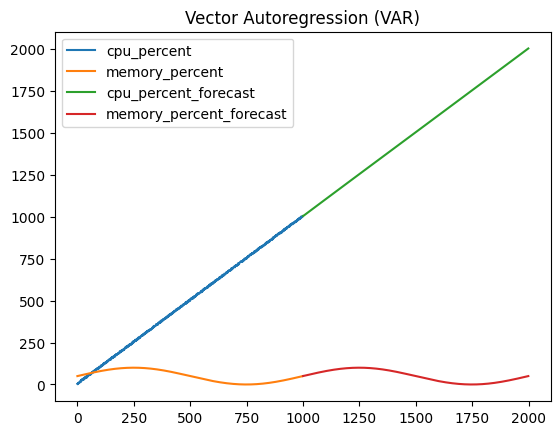

In [122]:
#new
df = pd.concat([df_train, df_test])
show_graph(df_train, df_results.loc[:, ['cpu_percent_forecast','memory_percent_forecast']], "Vector Autoregression (VAR)")


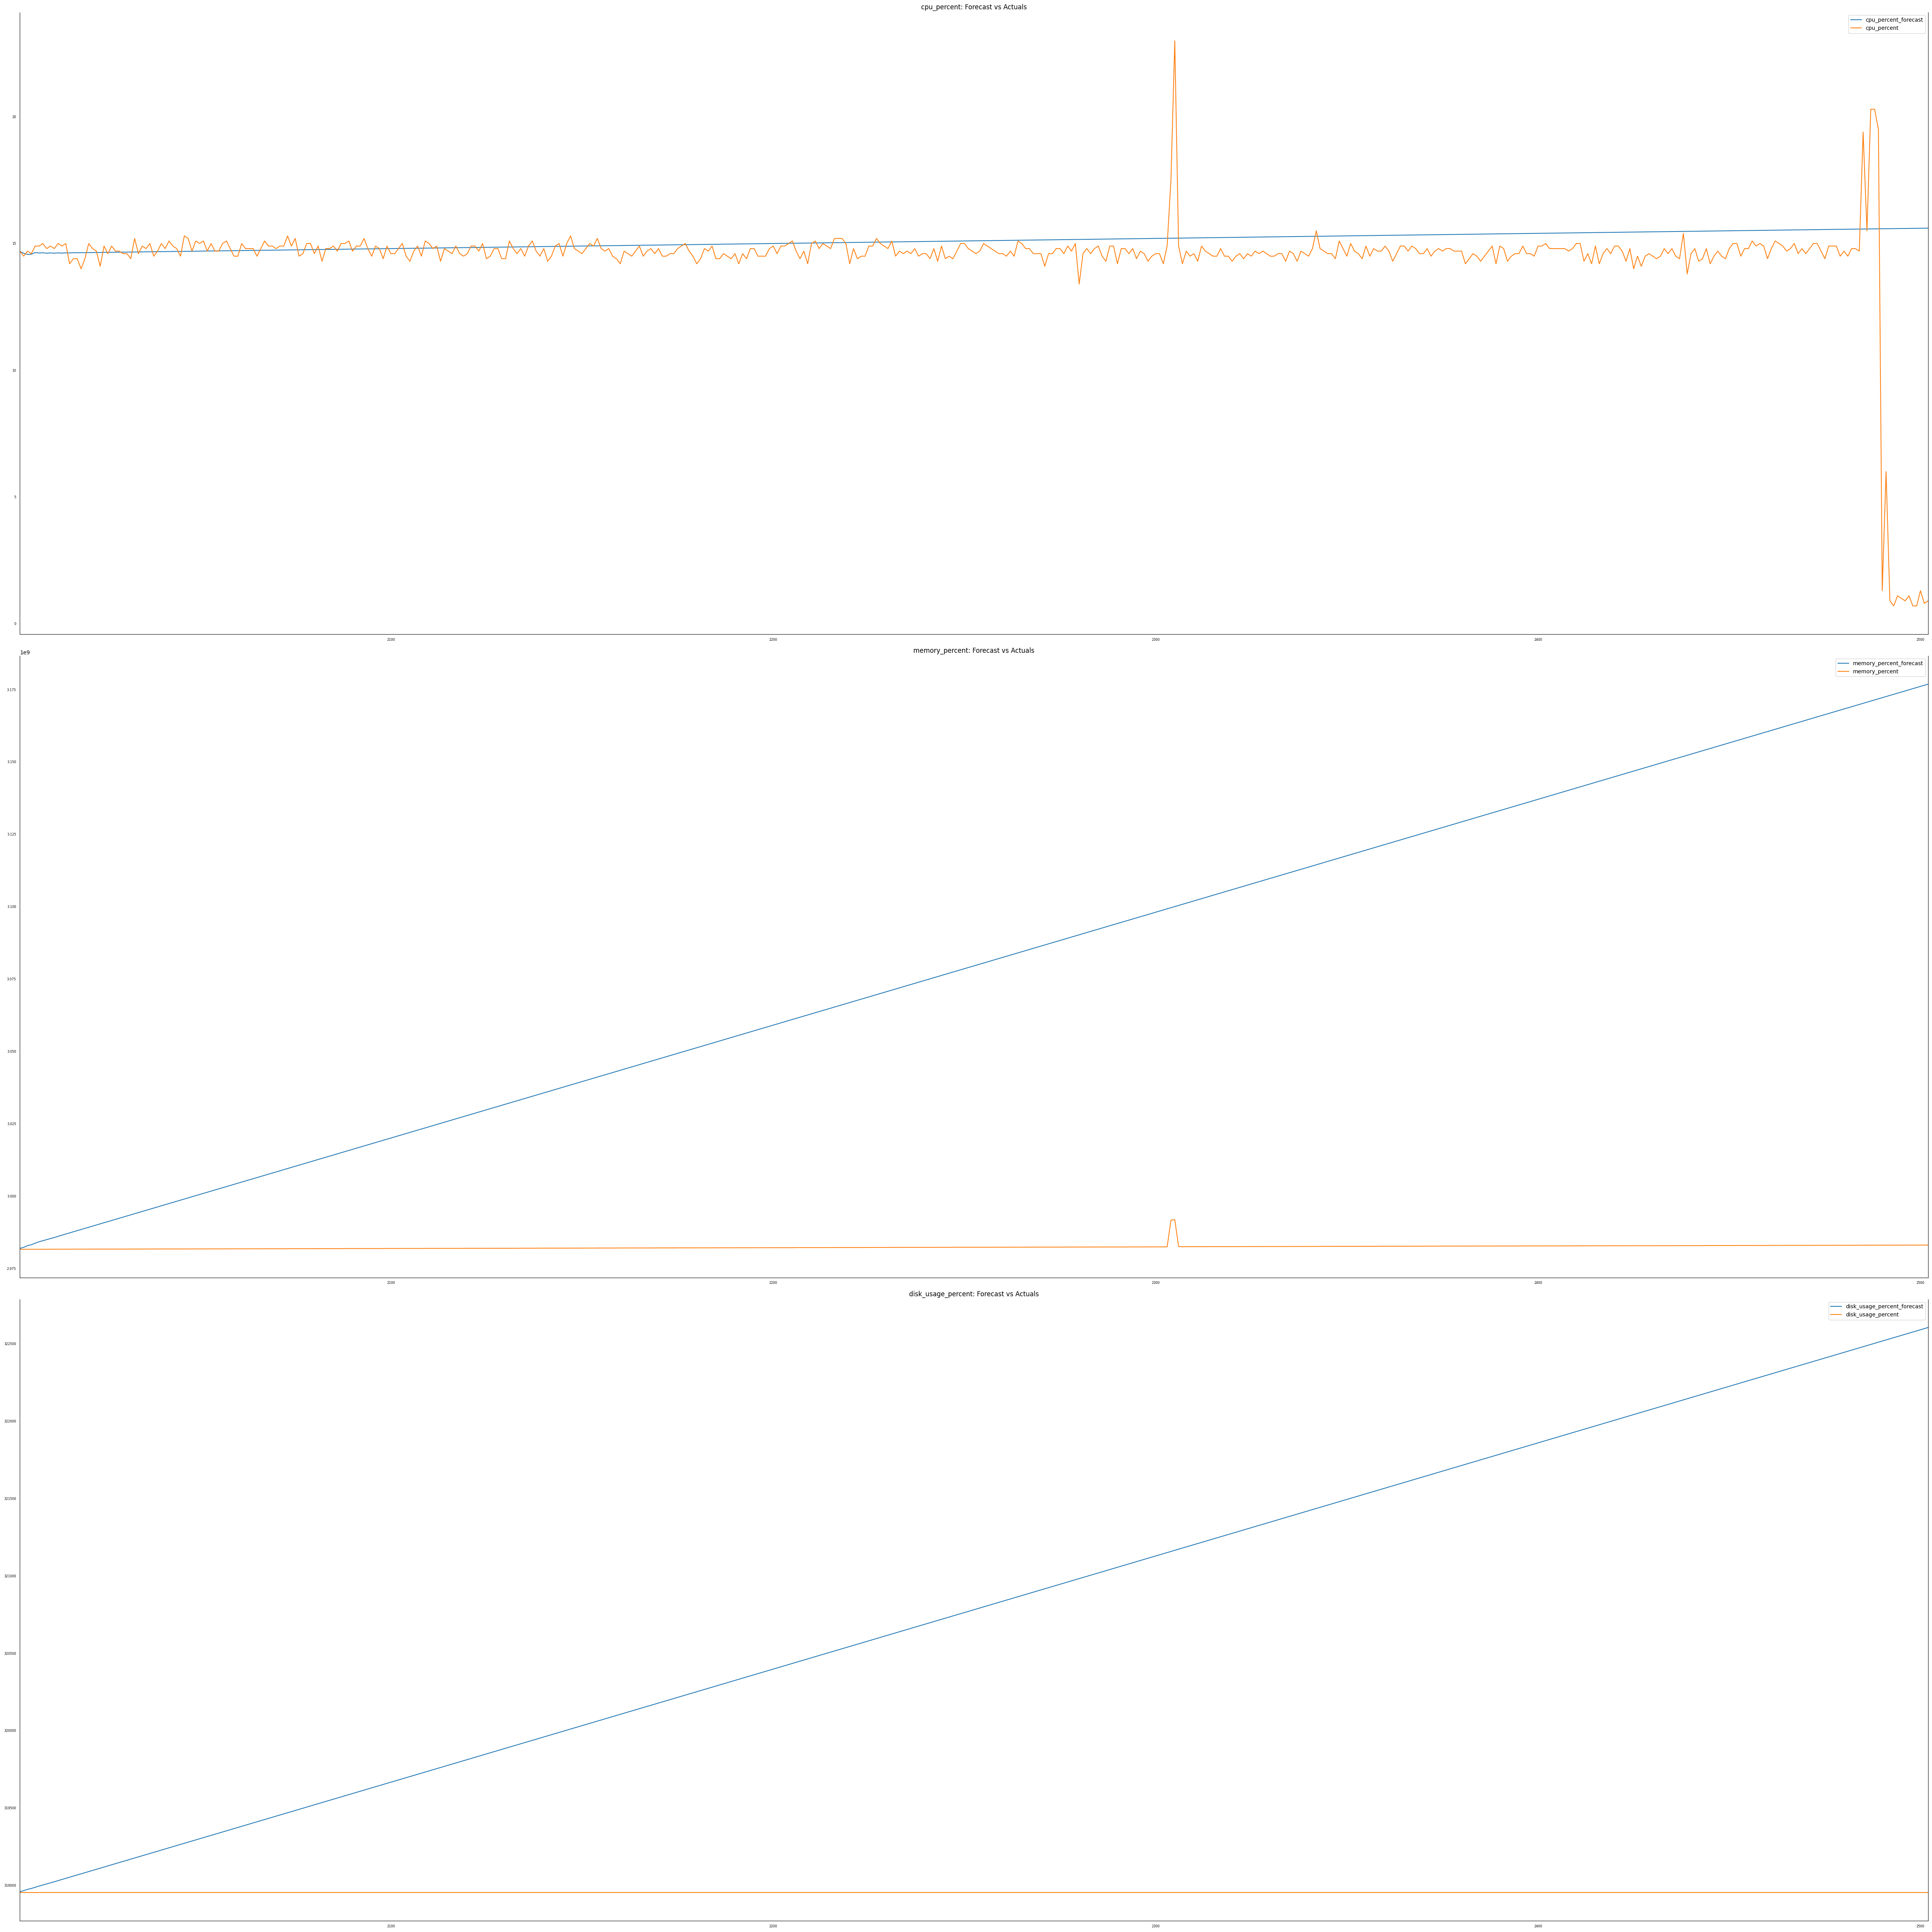

In [22]:
#fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=3, dpi=100, figsize=(50,8))

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(50,50))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [23]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: cpu_percent')
accuracy_prod = forecast_accuracy(df_results['cpu_percent_forecast'].values, df_test['cpu_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_user_time')
# accuracy_prod = forecast_accuracy(df_results['cpu_user_time_forecast'].values, df_test['cpu_user_time'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_system_time')
# accuracy_prod = forecast_accuracy(df_results['cpu_system_time_forecast'].values, df_test['cpu_system_time'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_idle_time')
# accuracy_prod = forecast_accuracy(df_results['cpu_idle_time_forecast'].values, df_test['cpu_idle_time'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_iowait')
# accuracy_prod = forecast_accuracy(df_results['cpu_iowait_forecast'].values, df_test['cpu_iowait'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_softirq')
# accuracy_prod = forecast_accuracy(df_results['cpu_softirq_forecast'].values, df_test['cpu_softirq'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_numbers_of_ctx_switches')
# accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_ctx_switches_forecast'].values, df_test['cpu_numbers_of_ctx_switches'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_numbers_of_interrupts')
# accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_interrupts_forecast'].values, df_test['cpu_numbers_of_interrupts'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_numbers_of_soft_interrupts')
# accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_soft_interrupts_forecast'].values, df_test['cpu_numbers_of_soft_interrupts'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: cpu_load_runable_state')
# accuracy_prod = forecast_accuracy(df_results['cpu_load_runable_state_forecast'].values, df_test['cpu_load_runable_state'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_percent')
accuracy_prod = forecast_accuracy(df_results['memory_percent_forecast'].values, df_test['memory_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_active')
# accuracy_prod = forecast_accuracy(df_results['memory_active_forecast'].values, df_test['memory_active'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_cached')
# accuracy_prod = forecast_accuracy(df_results['memory_cached_forecast'].values, df_test['memory_cached'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_shared')
# accuracy_prod = forecast_accuracy(df_results['memory_shared_forecast'].values, df_test['memory_shared'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_swap_percent')
# accuracy_prod = forecast_accuracy(df_results['memory_swap_percent_forecast'].values, df_test['memory_swap_percent'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_swap_sin')
# accuracy_prod = forecast_accuracy(df_results['memory_swap_sin_forecast'].values, df_test['memory_swap_sin'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: memory_swap_sout')
# accuracy_prod = forecast_accuracy(df_results['memory_swap_sout_forecast'].values, df_test['memory_swap_sout'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_usage_percent')
accuracy_prod = forecast_accuracy(df_results['disk_usage_percent_forecast'].values, df_test['disk_usage_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: disk_read_count')
# accuracy_prod = forecast_accuracy(df_results['disk_read_count_forecast'].values, df_test['disk_read_count'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: disk_write_count')
# accuracy_prod = forecast_accuracy(df_results['disk_write_count_forecast'].values, df_test['disk_write_count'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: disk_read_time')
# accuracy_prod = forecast_accuracy(df_results['disk_read_time_forecast'].values, df_test['disk_read_time'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: disk_write_time')
# accuracy_prod = forecast_accuracy(df_results['disk_write_time_forecast'].values, df_test['disk_write_time'])
# for k, v in accuracy_prod.items():
#      print(k, ': ', round(v,4))

Forecast Accuracy of: cpu_percent
mape :  0.4249
me :  0.6869
mae :  0.8704
mpe :  0.4146
rmse :  2.4318
corr :  -0.2423
minmax :  0.0556

Forecast Accuracy of: memory_percent
mape :  0.0326
me :  97162838.8852
mae :  97162838.8852
mpe :  0.0326
rmse :  112084661.5196
corr :  0.5982
minmax :  0.0312

Forecast Accuracy of: disk_usage_percent
mape :  0.0057
me :  1828.3109
mae :  1828.3109
mpe :  0.0057
rmse :  2110.8915
corr :  nan
minmax :  0.0057


<ipython-input-23-7b65c6b1c24e>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-23-7b65c6b1c24e>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [39]:
fc_vectors= df_results.drop(['cpu_percent_1d','memory_percent_1d','disk_usage_percent_1d'], axis='columns')
forecast_vectors = fc_vectors.to_numpy()

test_vectors = df_test.to_numpy()


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
forecast_vectors[1]


array([1.46156864e+01, 2.98230089e+09, 3.18965790e+05])

In [42]:
test_vectors[0]

array([1.47000000e+01, 2.98163405e+09, 3.18953000e+05])

In [43]:
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance



In [49]:
dist_list:list=[]
cosinedistance:list=[]
for i in range(nobs):
    
    dist = np.linalg.norm(forecast_vectors[i]-test_vectors[i])
    cosdist = distance.cosine(forecast_vectors[i],test_vectors[i])
    dotproduct = np.dot(forecast_vectors[i], test_vectors[i])
    print(str(forecast_vectors[i])+"|"+str(test_vectors[i])+"|"+str(dist)+"|"+str(cosdist))
    dist_list.append(dist)
    cosinedistance.append(cosdist)
    
    


[1.46804185e+01 2.98195095e+09 3.18959027e+05]|[1.47000000e+01 2.98163405e+09 3.18953000e+05]|316901.3033562667|2.220446049250313e-16
[1.46156864e+01 2.98230089e+09 3.18965790e+05]|[1.45000000e+01 2.98164224e+09 3.18953000e+05]|658654.9723994393|2.220446049250313e-16
[1.45689385e+01 2.98288795e+09 3.18973956e+05]|[1.47000000e+01 2.98164224e+09 3.18953000e+05]|1245709.0892318143|8.881784197001252e-16
[1.45779170e+01 2.98321668e+09 3.18979845e+05]|[1.46000000e+01 2.98164224e+09 3.18953000e+05]|1574442.4951801156|1.3322676295501878e-15
[1.46459206e+01 2.98373108e+09 3.18987483e+05]|[1.49000000e+01 2.98164224e+09 3.18953000e+05]|2088844.7052454625|2.1094237467877974e-15
[1.46238121e+01 2.98421631e+09 3.18995158e+05]|[1.49000000e+01 2.98164224e+09 3.18953000e+05]|2574073.8281636317|3.1086244689504383e-15
[1.46352725e+01 2.98459105e+09 3.19002128e+05]|[1.50000000e+01 2.98164224e+09 3.18953000e+05]|2948807.7212177785|4.107825191113079e-15
[1.46182773e+01 2.98497746e+09 3.19009342e+05]|[1.4800

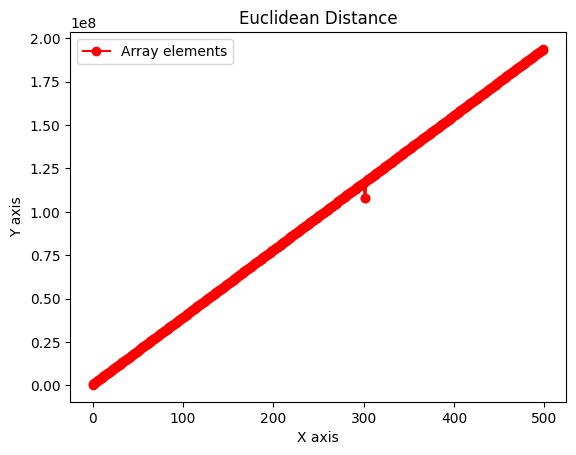

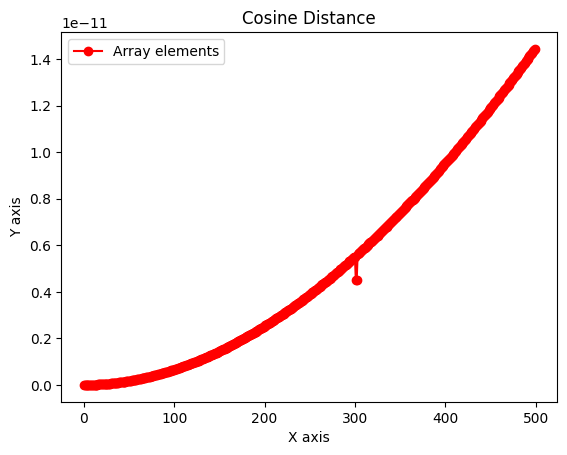

In [51]:

x = np.array(range(len(dist_list)))
y = dist_list
plt.title("Euclidean Distance")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")
plt.legend()
plt.show()


y = cosinedistance
plt.title("Cosine Distance")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")
plt.legend()
plt.show()